In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# number of validation images to use
# maximum number of training images
BASE_MODEL='DenseNet169' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 128 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 128
LEARN_RATE = 1e-4
RGB_FLIP = 1 # should rgb be flipped when rendering images

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')
val_image_dir = os.path.join(ship_dir, 'val')
import gc; gc.enable() # memory is tight

In [2]:
def prepare_train_set():

    masks = pd.read_csv(os.path.join('../input/',
                                     'train_ship_segmentations.csv.zip'))
    print(masks.shape[0], 'masks found')
    print(masks['ImageId'].value_counts().shape[0])
    masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))

    masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
    unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
    unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
    unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
    masks.drop(['ships'], axis=1, inplace=True)
    
    val_imgs = os.listdir(val_image_dir)
    val_idx = np.in1d(unique_img_ids.ImageId, val_imgs)
    val_df = unique_img_ids.loc[val_idx]
    train_df = unique_img_ids[np.logical_not(val_idx)]
    val_df = pd.merge(masks, val_df, on='ImageId', how='inner')
    train_df = pd.merge(masks, train_df, on='ImageId', how='inner')
    
    VALID_IMG_COUNT = len(val_df)
    val_df['path'] = val_df['ImageId'].map(lambda x: os.path.join(val_image_dir, x))
    
    return train_df, val_df

## Model

In [9]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [10]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.5, 1.5],
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)
valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [11]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [12]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               val_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 129668 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1362 images
(1362, 299, 299, 3) (1362, 1)


In [13]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (128, 299, 299, 3) float32 -2.117904 2.64
y (128, 1) float64 0.0 1.0


In [14]:
def get_model():

    base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                                  include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    
    from keras import models, layers
    from keras.optimizers import Adam
    img_in = layers.Input(t_x.shape[1:], name='Image_RGB_In')
    img_noise = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
    pt_features = base_pretrained_model(img_noise)
    pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
    bn_features = layers.BatchNormalization()(pt_features)
    feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features)
    gmp_dr = layers.GlobalMaxPooling2D()(feature_dropout)
    dr_steps = layers.Dropout(DROPOUT)(layers.Dense(DENSE_COUNT, activation = 'relu')(gmp_dr))
    out_layer = layers.Dense(1, activation = 'sigmoid')(dr_steps)

    ship_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

    ship_model.compile(optimizer = Adam(lr=LEARN_RATE), 
                       loss = 'binary_crossentropy',
                       metrics = ['binary_accuracy'])
    
    return ship_model

In [15]:
ship_model = get_model()

In [16]:
def train():
    from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
    weight_path="logs/boat_detecotr/{}_{}.best.hdf5".format('boat_detector', BASE_MODEL)

    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', save_weights_only = True)

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
    early = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=5) # probably needs to be more patient, but kaggle time is limited
    board = TensorBoard(log_dir='logs/boat_detecotr/{}'.format(BASE_MODEL),
                        histogram_freq=0, 
                        write_graph=True, write_images=False)
    callbacks_list = [checkpoint, early, reduceLROnPlat, board]
    
    train_gen.batch_size = BATCH_SIZE
    ship_model.fit_generator(train_gen, 
                          validation_data = (valid_x, valid_y), 
                          epochs = 300, 
                          callbacks = callbacks_list,
                          workers = 5,
                          max_queue_size=100,
                          #steps_per_epoch = round(50000 / BATCH_SIZE),
                          #validation_steps = round(VALID_IMG_COUNT / BATCH_SIZE),
                          use_multiprocessing=True)
    
    ship_model.load_weights(weight_path)
    ship_model.save('full_ship_model.h5')
    return ship_model

In [17]:
def load_weights(ship_model):
    weight_path="logs/boat_detecotr/{}_{}.best.hdf5".format('boat_detector', BASE_MODEL)
    ship_model.load_weights(weight_path)
    return ship_model

In [18]:
ship_model = load_weights(ship_model)

In [8]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')
submission_df = pd.read_csv('../input/sample_submission.csv.zip')
submission_df['path'] = submission_df['ImageId'].map(lambda x: os.path.join(test_image_dir, x))

88500 test images found


In [25]:
BATCH_SIZE = BATCH_SIZE*4
test_gen = flow_from_dataframe(valid_idg, 
                               submission_df, 
                             path_col = 'path',
                            y_col = 'ImageId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE, 
                              shuffle = False)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 88486 images


In [27]:
from tqdm import tqdm_notebook
all_scores = dict()
for _, (t_x, t_names) in zip(tqdm_notebook(range(test_gen.n//BATCH_SIZE+1)),
                            test_gen):
    t_y = ship_model.predict(t_x)[:, 0]
    for c_id, c_score in zip(t_names, t_y):
        all_scores[c_id] = c_score

In [28]:
submission_df['score'] = submission_df['ImageId'].map(lambda x: all_scores.get(x, 0))

In [3]:
vote = pd.read_csv('../result/vote.csv')

In [4]:
vote.rename({'vote_pick':'pre'},axis=1,inplace=True)

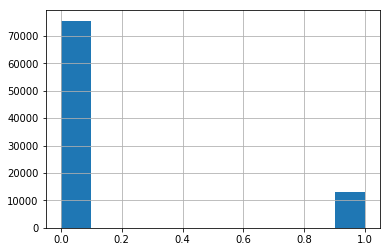

In [5]:
vote.pre.hist()

In [9]:
submission_df['score'] = vote.pre

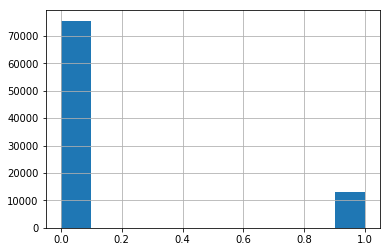

In [10]:
submission_df.score.hist()

(768, 768)
7691 748 8459 748 9227 748 9995 748 10763 748 1153


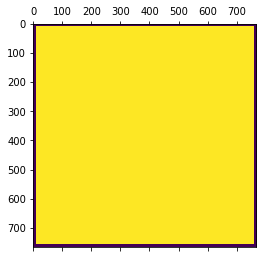

In [11]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

zp_dim = 10
out_img = np.ones((768-2*zp_dim, 768-2*zp_dim), dtype=bool)
out_img = np.pad(out_img, ((zp_dim, zp_dim),), mode='constant', constant_values=0)
plt.matshow(out_img)
print(out_img.shape)
pos_ship_str = rle_encode(out_img)
print(pos_ship_str[:50])

In [12]:
import kaggle_util
submission_df['EncodedPixels'] = submission_df['score'].map(lambda x: pos_ship_str if x>0.5 else None)
out_df = submission_df[['ImageId', 'EncodedPixels']]
kaggle_util.save_result(out_df, '../result/isship_{}.csv'.format('stack'), 
                        competition = 'airbus-ship-detection',
                        send = True, index = False)

save result
upload result
cmd: kaggle competitions submit -c airbus-ship-detection -f ../result/isship_stack.csv.7z -m "submit"
